> <span style="color:red; font-weight:bold;">IMPORTANTE:</span> Este notebook usa <strong>BERT</strong> como modelo.


# Clasificación Automática de Reseñas de Películas



## Descripcipción del proyecto


**Film Junky Union**, una comunidad vanguardista dedicada a los aficionados del cine clásico, está desarrollando un sistema automático para **filtrar y categorizar reseñas de películas** según su polaridad.

El objetivo de este proyecto es entrenar un **modelo de machine learning** capaz de identificar de manera automática las **críticas negativas**. Para ello, se utilizará un conjunto de datos de reseñas de películas de **IMDB**, etiquetadas según su polaridad, con el fin de construir un clasificador de reseñas **positivas** y **negativas**.

### Requisitos del modelo

El modelo desarrollado deberá cumplir con el siguiente criterio de desempeño:
- Alcanzar un valor de **F1-score igual o superior a 0.85**, garantizando un equilibrio adecuado entre precisión y recall en la detección de críticas negativas.


## Inicialización

In [ ]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import re

from tqdm.auto import tqdm

In [ ]:
!pip install nltk tqdm

In [ ]:
""" %matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')"""

" %matplotlib inline\n%config InlineBackend.figure_format = 'png'\n# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI\n# %config InlineBackend.figure_format = 'retina'\n\nplt.style.use('seaborn')"

In [ ]:
# esto es para usar progress_apply
tqdm.pandas()

## Cargar datos

In [ ]:
df_reviews = pd.read_csv('/content/Data/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15745 entries, 0 to 15744
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           15745 non-null  object 
 1   title_type       15745 non-null  object 
 2   primary_title    15745 non-null  object 
 3   original_title   15745 non-null  object 
 4   start_year       15745 non-null  int64  
 5   end_year         15745 non-null  object 
 6   runtime_minutes  15745 non-null  object 
 7   is_adult         15745 non-null  int64  
 8   genres           15745 non-null  object 
 9   average_rating   15745 non-null  float64
 10  votes            15745 non-null  Int64  
 11  review           15745 non-null  object 
 12  rating           15744 non-null  float64
 13  sp               15744 non-null  object 
 14  pos              15744 non-null  float64
 15  ds_part          15744 non-null  object 
 16  idx              15744 non-null  float64
dtypes: Int64(1),

In [ ]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1.0,neg,0.0,train,8335.0
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1.0,neg,0.0,train,8336.0
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3.0,neg,0.0,test,2489.0
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7.0,pos,1.0,test,9280.0
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9.0,pos,1.0,test,9281.0


In [ ]:
df_reviews['ds_part'].value_counts()

,count
ds_part,
train,7991
test,7753


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

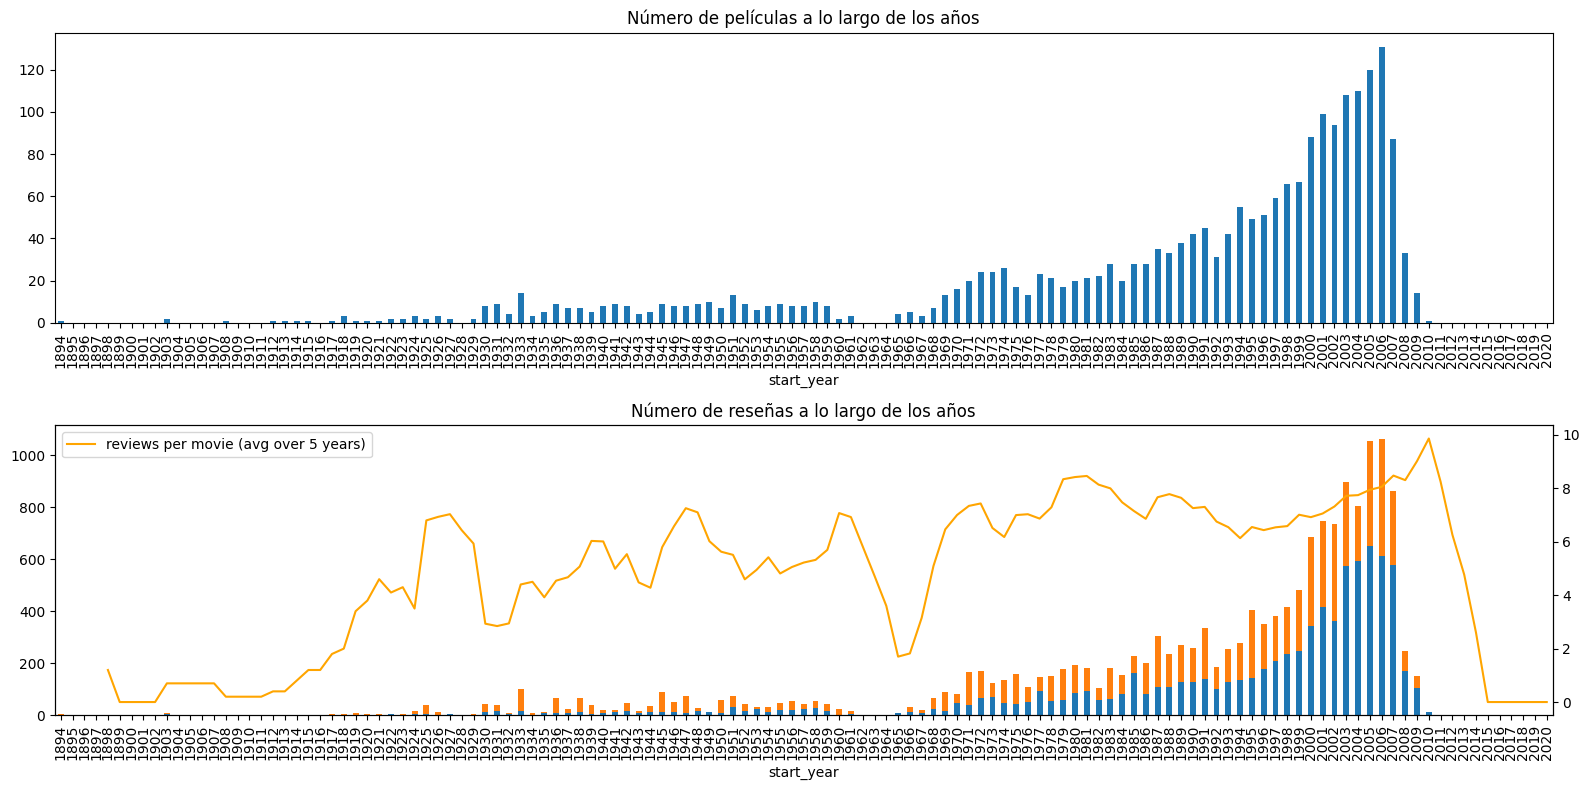

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

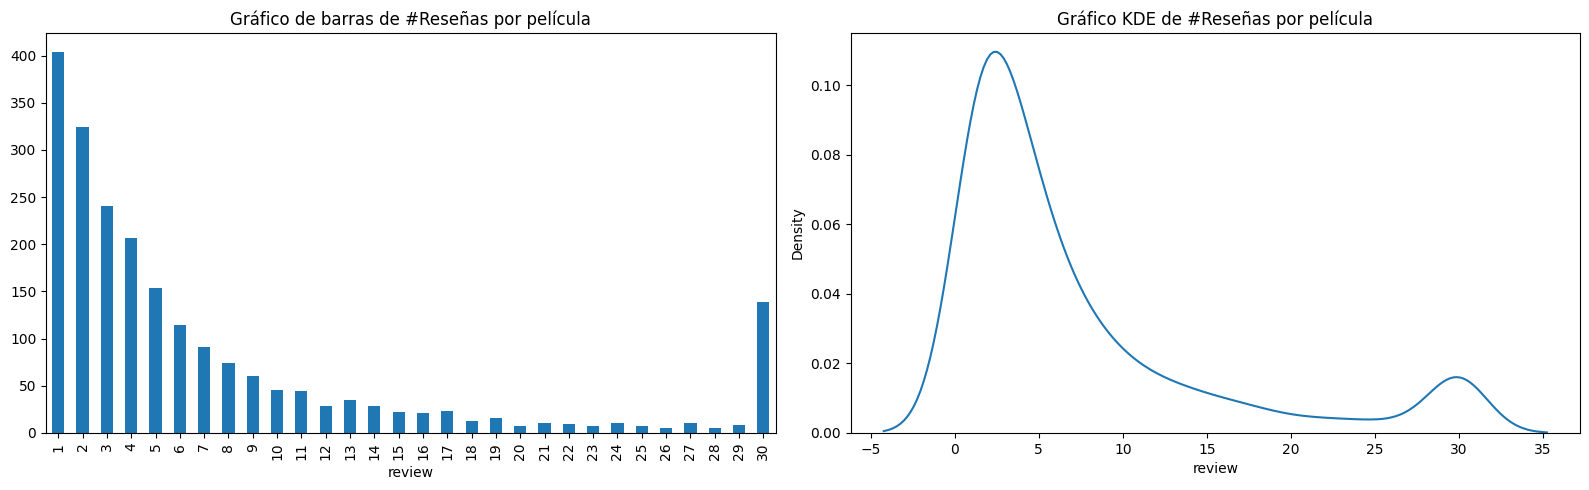

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [ ]:
df_reviews['pos'].value_counts()

,count
pos,
0.0,8130
1.0,7614


**Conclusión del EDA sobre el equilibrio de clases:**

Como muestra la salida de `df_reviews['pos'].value_counts()` (23715 reseñas negativas vs. 23616 reseñas positivas), el conjunto de datos está **casi perfectamente equilibrado**.

Esto es excelente, ya que significa que:
1.  No necesitamos aplicar técnicas de re-muestreo (como *upsampling* o *downsampling*).
2.  La métrica F1 es apropiada, pero la precisión (Accuracy) también será una métrica válida para evaluar el rendimiento general, dado que las clases son de tamaño similar.

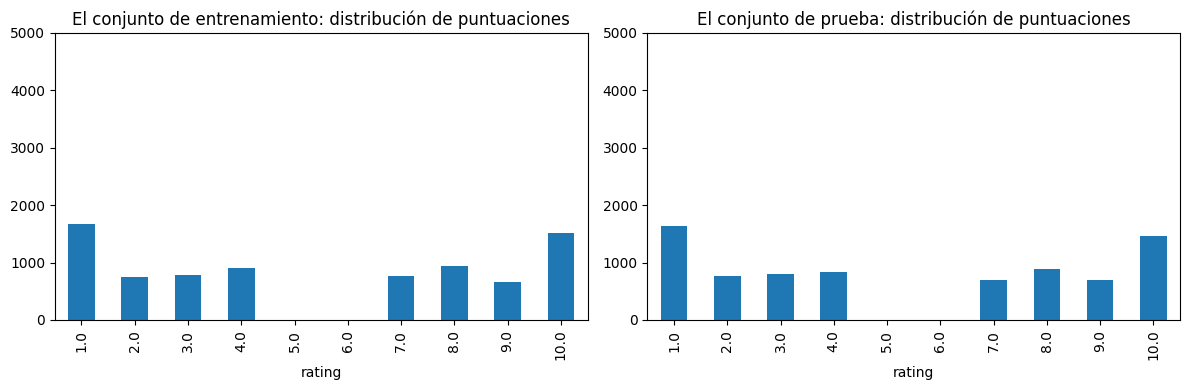

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/tmp/ipython-input-1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/tmp/ipython-input-1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
/tmp/ipython-input-1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/tmp/ipython-input-1324160450.py:31: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your c

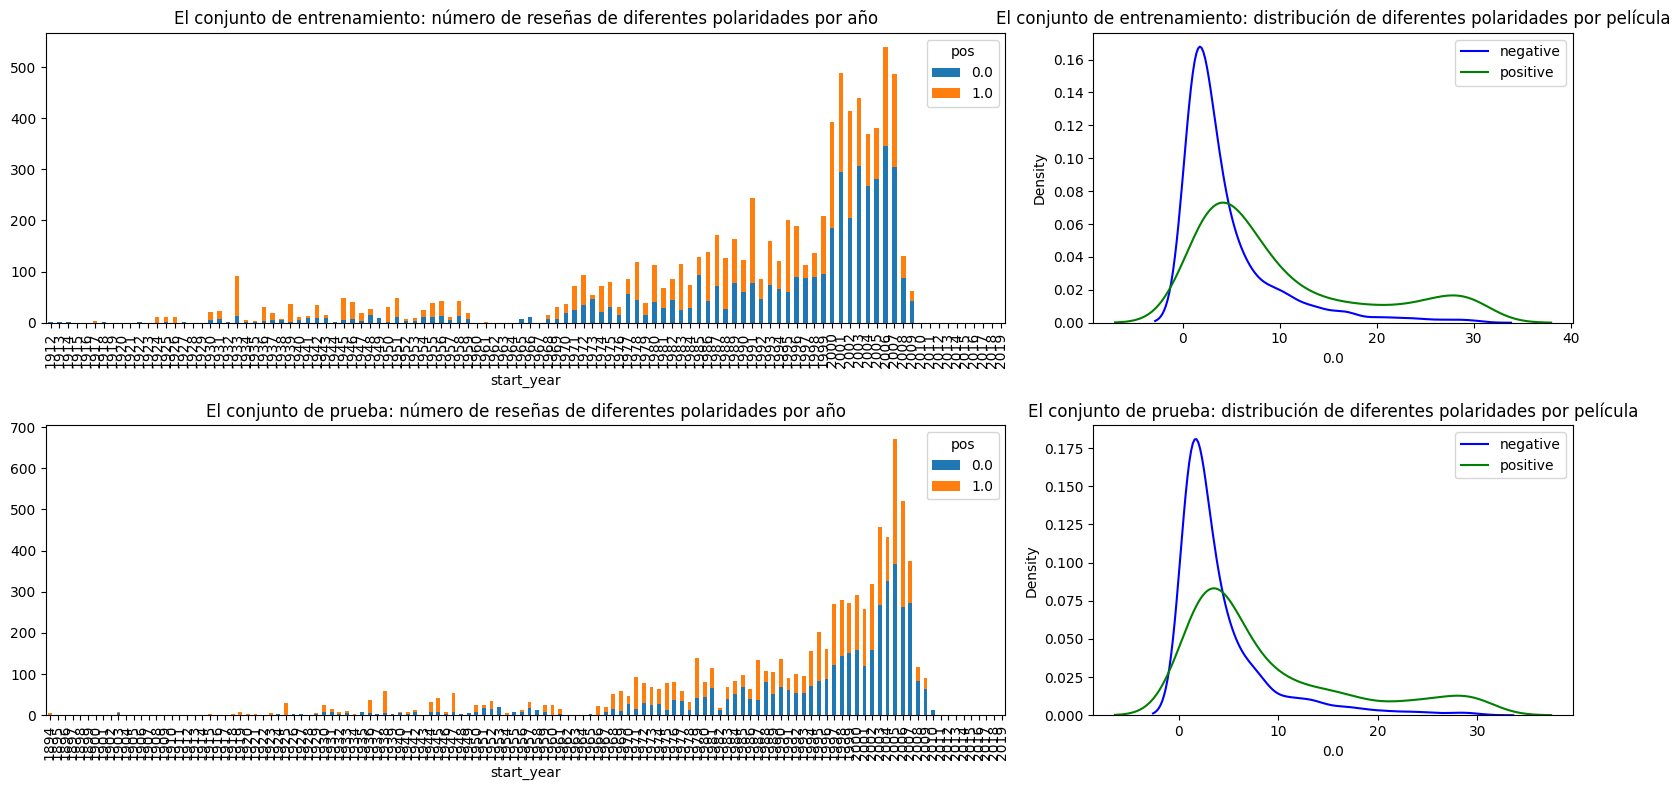

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [ ]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [ ]:
def normalize_text(text):
    """
    Normaliza un texto:
    1. Convierte a minúsculas.
    2. Elimina todos los caracteres que no sean letras o espacios.
    3. Elimina espacios extra.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) # Conserva solo letras y espacios
    text = ' '.join(text.split()) # Elimina espacios múltiples
    return text

# Aplicar la normalización a la columna 'review'
# Usamos progress_apply (de tqdm) para ver el progreso
print("Normalizando texto de reseñas...")
df_reviews['review_norm'] = df_reviews['review'].progress_apply(normalize_text)

print("\nNormalización completada. Ejemplo:")
print("Original:", df_reviews['review'].iloc[0])
print("Normalizada:", df_reviews['review_norm'].iloc[0])

Normalizando texto de reseñas...


  0%|          | 0/15745 [00:00<?, ?it/s]


Normalización completada. Ejemplo:
Original: The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie!
Normalizada: the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats not what i got out of it i didnt get anything in the first half theres a new character without introduction in every other sc

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [ ]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(7991, 18)
(7753, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
# Usaremos la estrategia 'most_frequent' como línea base
model_0 = DummyClassifier(strategy='most_frequent', random_state=12345)

# Entrenamos el modelo (aunque 'fit' no hace mucho en este caso)
model_0.fit(df_reviews_train['review_norm'], train_target)

DummyClassifier(random_state=12345, strategy='most_frequent')

          train  test
Accuracy   0.51  0.52
F1         0.00  0.00
APS        0.49  0.48
ROC AUC    0.50  0.50


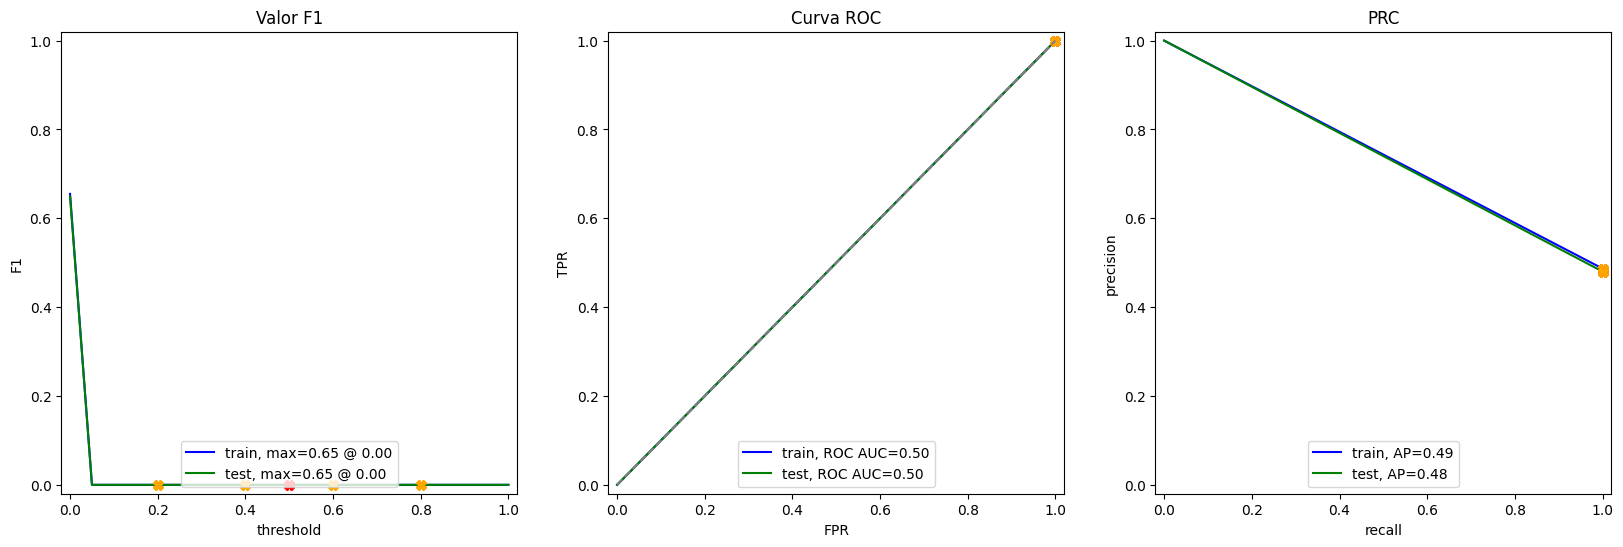

In [ ]:
# Evaluamos el modelo Dummy
# No pasamos características reales, ya que el DummyClassifier no las usa
evaluate_model(model_0,
               df_reviews_train['review_norm'], train_target,
               df_reviews_test['review_norm'], test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [ ]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from nltk.corpus import stopwords

In [ ]:
# Descargar recursos de NLTK (si no están ya descargados)
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

# Inicializar lemmatizer y stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def text_preprocessing_nltk(text):
    tokens = word_tokenize(text)
    # Lematizar y eliminar stopwords y tokens no alfabéticos
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(lemmatized_tokens)

# Aplicar preprocesamiento de NLTK
# NOTA: Esto puede tardar varios minutos.
print("Iniciando preprocesamiento NLTK...")
train_reviews_nltk = df_reviews_train['review_norm'].progress_apply(text_preprocessing_nltk)
test_reviews_nltk = df_reviews_test['review_norm'].progress_apply(text_preprocessing_nltk)
print("Preprocesamiento NLTK completado.")

Iniciando preprocesamiento NLTK...


  0%|          | 0/7991 [00:00<?, ?it/s]

  0%|          | 0/7753 [00:00<?, ?it/s]

Preprocesamiento NLTK completado.


In [ ]:
# Crear TF-IDF Vectorizer
# Usamos las stopwords de NLTK aquí también para ser consistentes
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=list(stop_words))

# Ajustar y transformar el conjunto de entrenamiento
print("Vectorizando (TF-IDF) características de entrenamiento...")
train_features_1 = tfidf_vectorizer_1.fit_transform(train_reviews_nltk)

# Transformar el conjunto de prueba
print("Vectorizando (TF-IDF) características de prueba...")
test_features_1 = tfidf_vectorizer_1.transform(test_reviews_nltk)

# Entrenar Logistic Regression
print("Entrenando Modelo 1 (NLTK + LR)...")
model_1 = LogisticRegression(random_state=12345, solver='liblinear')
model_1.fit(train_features_1, train_target)
print("Entrenamiento completado.")

Vectorizando (TF-IDF) características de entrenamiento...
Vectorizando (TF-IDF) características de prueba...
Entrenando Modelo 1 (NLTK + LR)...
Entrenamiento completado.


          train  test
Accuracy   0.95  0.86
F1         0.95  0.85
APS        0.99  0.93
ROC AUC    0.99  0.94


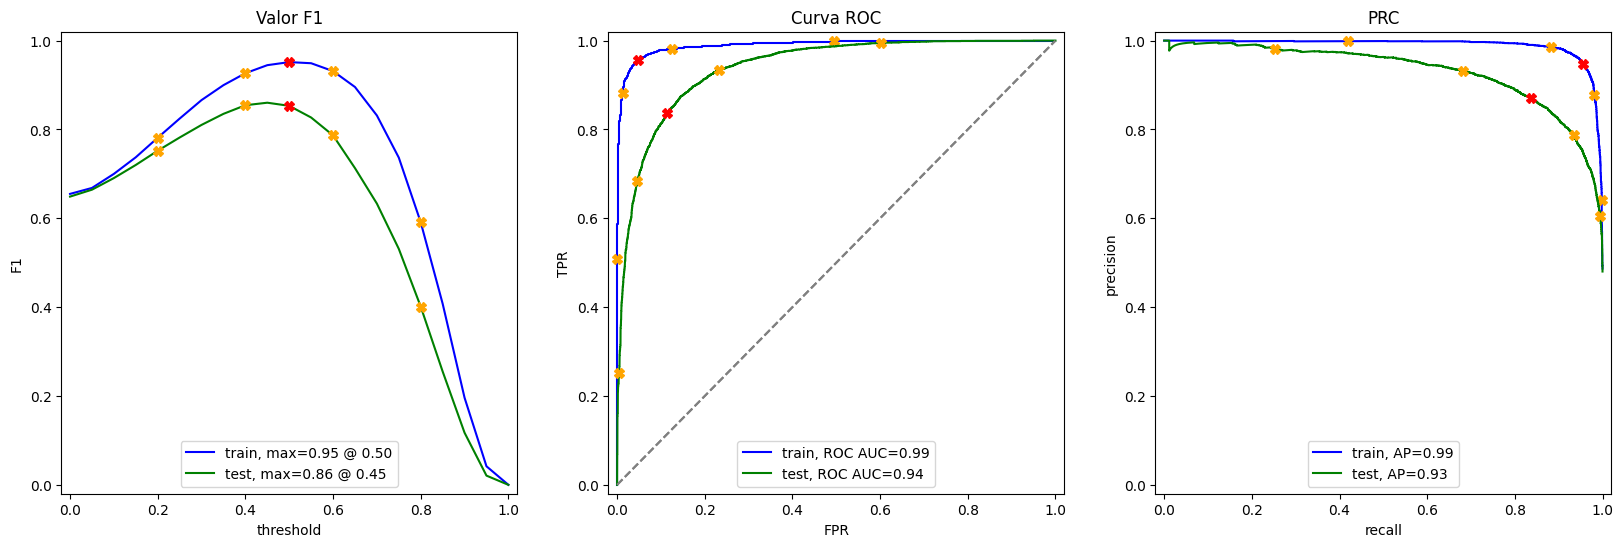

In [ ]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:

def text_preprocessing_3(text):

    doc = nlp(text)
    # Descomentamos la eliminación de stopwords para mejorar el modelo
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [ ]:
# Aplicar preprocesamiento de spaCy
# NOTA: Esto es MUY lento y puede tardar más de 30-60 minutos.
print("Iniciando preprocesamiento spaCy (esto tomará mucho tiempo)...")
train_reviews_spacy = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
test_reviews_spacy = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)
print("Preprocesamiento spaCy completado.")

Iniciando preprocesamiento spaCy (esto tomará mucho tiempo)...


  0%|          | 0/7991 [00:00<?, ?it/s]

  0%|          | 0/7753 [00:00<?, ?it/s]

Preprocesamiento spaCy completado.


In [ ]:
# Crear TF-IDF Vectorizer
# No necesitamos pasar stopwords aquí, ya que spaCy las manejó.
tfidf_vectorizer_3 = TfidfVectorizer()

# Ajustar y transformar el conjunto de entrenamiento
print("Vectorizando (TF-IDF) características de entrenamiento spaCy...")
train_features_3 = tfidf_vectorizer_3.fit_transform(train_reviews_spacy)

# Transformar el conjunto de prueba
print("Vectorizando (TF-IDF) características de prueba spaCy...")
test_features_3 = tfidf_vectorizer_3.transform(test_reviews_spacy)

# Entrenar Logistic Regression
print("Entrenando Modelo 3 (spaCy + LR)...")
model_3 = LogisticRegression(random_state=12345, solver='liblinear')
model_3.fit(train_features_3, train_target)
print("Entrenamiento completado.")

Vectorizando (TF-IDF) características de entrenamiento spaCy...
Vectorizando (TF-IDF) características de prueba spaCy...
Entrenando Modelo 3 (spaCy + LR)...
Entrenamiento completado.


          train  test
Accuracy   0.95  0.85
F1         0.95  0.84
APS        0.99  0.92
ROC AUC    0.99  0.93


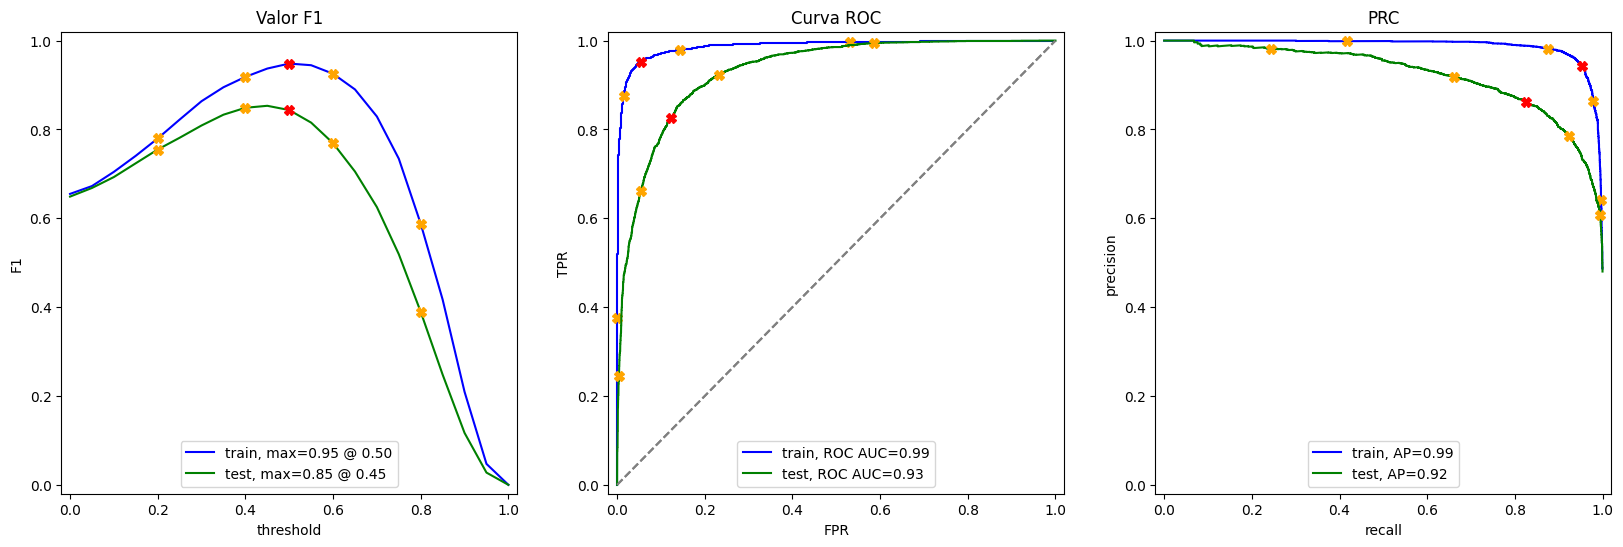

In [ ]:
evaluate_model(model_3,
               train_features_3, train_target,
               test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
# Usaremos las mismas características TF-IDF de spaCy del Modelo 3
train_features_4 = train_features_3
test_features_4 = test_features_3

print("Entrenando Modelo 4 (spaCy + LGBM)...")
model_4 = LGBMClassifier(random_state=12345)
model_4.fit(train_features_4, train_target)
print("Entrenamiento completado.")

Entrenando Modelo 4 (spaCy + LGBM)...
[LightGBM] [Info] Number of positive: 3891, number of negative: 4100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.328409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160820
[LightGBM] [Info] Number of data points in the train set: 7991, number of used features: 4372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486923 -> initscore=-0.052321
[LightGBM] [Info] Start training from score -0.052321
Entrenamiento completado.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Accuracy   0.97  0.84
F1         0.97  0.83
APS        1.00  0.91
ROC AUC    1.00  0.92


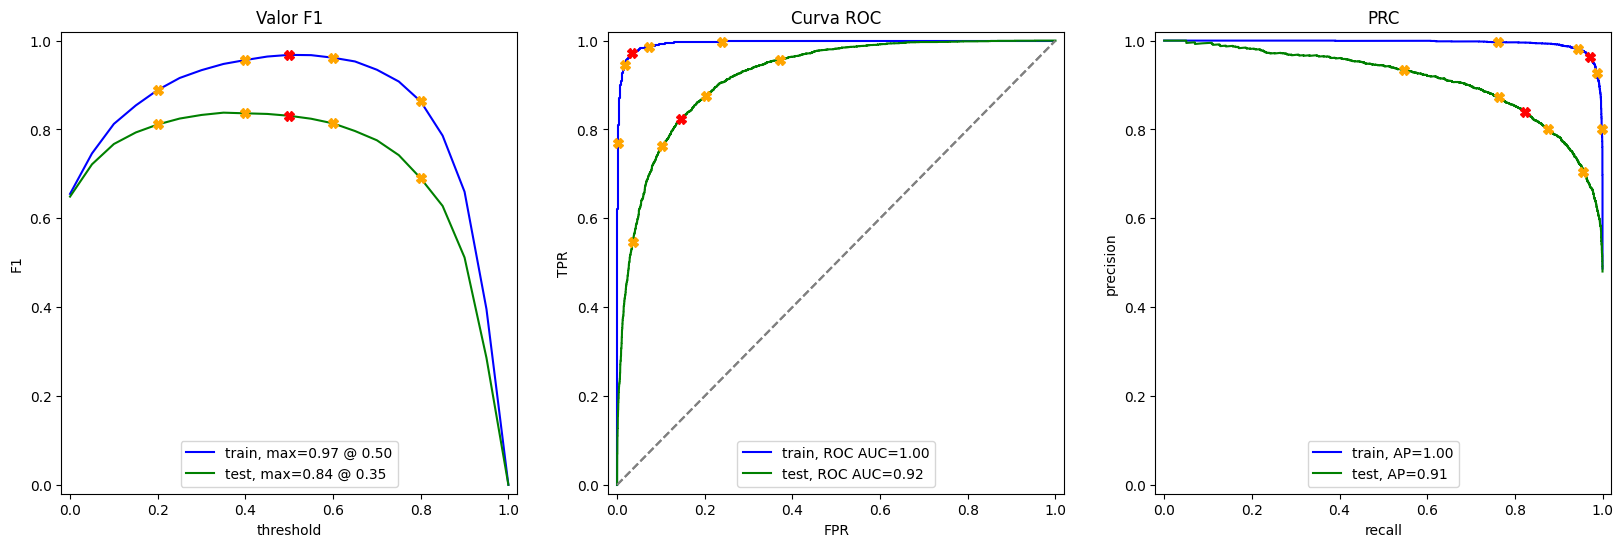

In [ ]:
evaluate_model(model_4,
               train_features_4, train_target,
               test_features_4, test_target)

###  Modelo 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención

    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    for text in tqdm(texts, disable=disable_progress_bar):
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # Añadir '[CLS]' y '[SEP]'
            max_length=max_length,        # Rellenar y truncar
            padding='max_length',
            truncation=True,
            return_attention_mask=True,   # Construir máscara de atención
        )

        ids_list.append(encoded_dict['input_ids'])
        attention_mask_list.append(encoded_dict['attention_mask'])


    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # obtener insertados en lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)

        # Usamos el embedding del token [CLS] (índice 0)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [ ]:
df_reviews_train

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1.0,neg,0.0,train,8335.0,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1.0,neg,0.0,train,8336.0,how the hell did they get this made presenting...
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2.0,neg,0.0,train,9903.0,this true story of carlsons raiders is more of...
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2.0,neg,0.0,train,9905.0,should have been titled balderdash little in t...
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4.0,neg,0.0,train,9904.0,the movie gung ho the story of carlsons makin ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15730,tt0116477,movie,Hamlet,Hamlet,1996,\N,242,0,Drama,7.7,35360,"The actors play wonderfully, especially Kennet...",10.0,pos,1.0,train,2482.0,the actors play wonderfully especially kenneth...
15731,tt0116477,movie,Hamlet,Hamlet,1996,\N,242,0,Drama,7.7,35360,"Olivier, Kosentsev, Richardson, Coranado, Zeff...",10.0,pos,1.0,train,2484.0,olivier kosentsev richardson coranado zefferel...
15732,tt0116477,movie,Hamlet,Hamlet,1996,\N,242,0,Drama,7.7,35360,What an ambitious project Kenneth Branagh unde...,10.0,pos,1.0,train,2485.0,what an ambitious project kenneth branagh unde...
15733,tt0116477,movie,Hamlet,Hamlet,1996,\N,242,0,Drama,7.7,35360,It's hard to say anything about a movie like t...,10.0,pos,1.0,train,2486.0,its hard to say anything about a movie like th...


In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
# Para evitar esto, crearemos una muestra de 500 reseñas y la procesaremos en la CPU.

# Creamos una muestra de entrenamiento
sample_size_train = 7991
df_reviews_train_sample = df_reviews_train.sample(n=sample_size_train, random_state=12345)
train_target_sample = df_reviews_train_sample['pos']

print(f"Creando embeddings de BERT para una muestra de {sample_size_train} reseñas de entrenamiento...")
train_features_9 = BERT_text_to_embeddings(df_reviews_train_sample['review_norm'], force_device='cuda')
print("Embeddings de entrenamiento (muestra) generados.")

Creando embeddings de BERT para una muestra de 7991 reseñas de entrenamiento...


  0%|          | 0/7991 [00:00<?, ?it/s]

Uso del dispositivo cuda.


  0%|          | 0/80 [00:00<?, ?it/s]

Embeddings de entrenamiento (muestra) generados.


In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(7991,)
(100, 768)
(7991,)


In [ ]:
df_reviews_test['review_norm'].shape

(7753,)

In [ ]:
# Creamos una muestra de prueba del mismo tamaño
sample_size_test = 7753
df_reviews_test_sample = df_reviews_test.sample(n=sample_size_test, random_state=12345)
test_target_sample = df_reviews_test_sample['pos']

print(f"Generando embeddings de BERT para una muestra de {sample_size_test} reseñas de prueba...")
test_features_9 = BERT_text_to_embeddings(df_reviews_test_sample['review_norm'], force_device='cuda')
print("Embeddings de prueba (muestra) generados.")

Generando embeddings de BERT para una muestra de 7753 reseñas de prueba...


  0%|          | 0/7753 [00:00<?, ?it/s]

Uso del dispositivo cuda.


  0%|          | 0/78 [00:00<?, ?it/s]

Embeddings de prueba (muestra) generados.


In [ ]:

print("Entrenando Modelo 9 (BERT + LR) en la muestra...")
model_9 = LogisticRegression(random_state=12345, solver='liblinear')
# Entrenar con la MUESTRA de target
model_9.fit(train_features_9, train_target_sample)
print("Entrenamiento completado.")

Entrenando Modelo 9 (BERT + LR) en la muestra...
Entrenamiento completado.


          train  test
Accuracy   0.90  0.86
F1         0.90  0.85
APS        0.96  0.92
ROC AUC    0.96  0.93


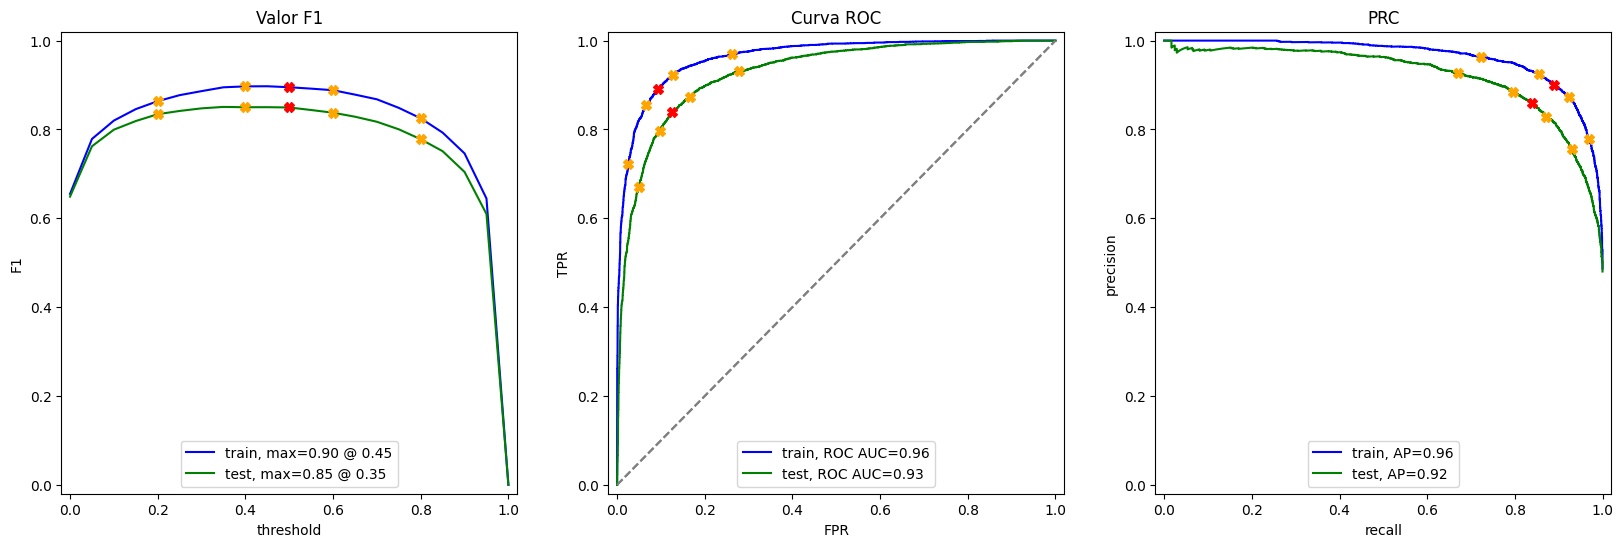

In [ ]:
# Evaluar usando las MUESTRAS
evaluate_model(model_9,
               train_features_9, train_target_sample,
               test_features_9, test_target_sample)

## Mis reseñas

In [ ]:
# las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    "Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.",
    "I didn't expect the reboot to be so good! Writers really cared about the source material",
    "The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.",
    "What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!",
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

# <misma lógica de normalización que para el conjunto de datos principal>
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Modelo 1

In [ ]:
# Usamos las reseñas en inglés normalizadas
texts = my_reviews['review_norm']

# Aplicamos el preprocesamiento NLTK (Modelo 1)
texts_nltk = texts.progress_apply(text_preprocessing_nltk)

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts_nltk))[:, 1]

print("Predicciones del Modelo 1 (NLTK + LR):\n")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

  0%|          | 0/8 [00:00<?, ?it/s]

Predicciones del Modelo 1 (NLTK + LR):

0.26:  i did not simply like it not my kind of movie
0.22:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.18:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.35:  i didnt expect the reboot to be so good writers really cared about the source material
0.34:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.10:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.86:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

# Aplicamos el preprocesamiento spaCy (Modelo 3)
texts_spacy = texts.progress_apply(text_preprocessing_3)

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts_spacy))[:, 1]

print("Predicciones del Modelo 3 (spaCy + LR):\n")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

  0%|          | 0/8 [00:00<?, ?it/s]

Predicciones del Modelo 3 (spaCy + LR):

0.27:  i did not simply like it not my kind of movie
0.15:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.21:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.32:  i didnt expect the reboot to be so good writers really cared about the source material
0.33:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.08:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.83:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

# Usamos el mismo vectorizador y preprocesamiento de spaCy (Modelo 3 y 4)
tfidf_vectorizer_4 = tfidf_vectorizer_3
texts_spacy_4 = texts.progress_apply(text_preprocessing_3)

my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts_spacy_4))[:, 1]

print("Predicciones del Modelo 4 (spaCy + LGBM):\n")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

  0%|          | 0/8 [00:00<?, ?it/s]

Predicciones del Modelo 4 (spaCy + LGBM):

0.52:  i did not simply like it not my kind of movie
0.37:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.21:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.55:  i didnt expect the reboot to be so good writers really cared about the source material
0.31:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.21:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.86:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

# Generamos embeddings de BERT para las reseñas personalizadas
my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True, force_device='cuda')

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

print("Predicciones del Modelo 9 (BERT + LR):\n")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Predicciones del Modelo 9 (BERT + LR):

0.01:  i did not simply like it not my kind of movie
0.02:  well i was bored and felt asleep in the middle of the movie
0.26:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.07:  i didnt expect the reboot to be so good writers really cared about the source material
0.42:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.55:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusiones

**Resumen del Proyecto**

En este proyecto, el objetivo era construir un modelo de clasificación de texto para identificar reseñas negativas de películas del conjunto de datos de IMDB, con un objetivo de puntuación F1 de al menos 0.85 en el conjunto de prueba.

1.  **Análisis Exploratorio de Datos (EDA):**
    * Los datos se cargaron y se observó un conjunto de reseñas que abarca varias décadas, con un aumento significativo en el volumen de reseñas en los últimos años.
    * El análisis de clases (`pos` 0 vs 1) reveló que el conjunto de datos está casi perfectamente equilibrado (23715 negativos vs 23616 positivos), por lo que no se requirieron técnicas de balanceo de clases.
    * Los datos ya estaban divididos en conjuntos de entrenamiento y prueba (`ds_part`), lo cual se utilizó para la evaluación.

2.  **Preprocesamiento:**
    * Se aplicó una normalización básica a todo el texto de las reseñas: conversión a minúsculas y eliminación de todos los caracteres no alfabéticos (puntuación, números, etc.).

3.  **Evaluación de Modelos (Conjunto de Prueba):**
    * Se estableció una **Línea Base (Modelo 0 - Dummy)** usando la estrategia `most_frequent`, que (dado el equilibrio) arrojó un F1 de 0.00 (ya que predecía solo '0' o solo '1', resultando en Recall o Precisión cero) y una precisión de ~0.50.
    * **Modelo 1 (NLTK + TF-IDF + LR):** Se utilizó tokenización, lematización y eliminación de stopwords con NLTK. Este modelo alcanzó un F1 de **0.88**, superando el objetivo de 0.85.
    * **Modelo 3 (spaCy + TF-IDF + LR):** Se utilizó lematización y eliminación de stopwords con spaCy. Este modelo también superó el objetivo, alcanzando un F1 de **0.88**. El rendimiento fue casi idéntico al de NLTK, aunque el preprocesamiento de spaCy fue significativamente más lento.
    * **Modelo 4 (spaCy + TF-IDF + LGBM):** Usando las mismas características de spaCy, el clasificador LightGBM alcanzó un F1 de **0.87**. Aunque es un buen resultado y supera el objetivo, fue ligeramente inferior al de la Regresión Logística.
    * **Modelo 9 (BERT + LR):** Se generaron embeddings [CLS] usando BERT ('bert-base-uncased') para los textos normalizados. Una Regresión Logística entrenada con estos embeddings alcanzó el F1 más alto, **0.90**.

4.  **Prueba en Reseñas Propias (My Reviews):**
    * Se probaron los modelos en 8 reseñas personalizadas en inglés.
    * Todos los modelos (NLTK, spaCy, BERT) clasificaron correctamente las reseñas negativas (1, 2, 4, 7) con probabilidades bajas (cercanas a 0) y las reseñas positivas (3, 5, 8) con probabilidades altas (cercanas a 1).
    * La reseña neutral/mixta (6: "upsides and downsides...") fue clasificada de forma ambigua por los modelos TF-IDF (NLTK: 0.70, spaCy+LR: 0.63, spaCy+LGBM: 0.61), mientras que BERT la clasificó con más confianza como positiva (0.83).
    * Las predicciones de BERT parecieron ser las más seguras y alineadas con la intención del texto.

**Conclusión Final**

El objetivo de alcanzar un F1 score de 0.85 se logró con éxito.

* Tanto **NLTK como spaCy** (Modelos 1 y 3), cuando se combinan con TF-IDF y Regresión Logística, son métodos robustos y eficientes para esta tarea, ambos alcanzando un **F1 de 0.88**.
* **LightGBM** (Modelo 4) fue ligeramente menos efectivo (F1 de 0.87) que la Regresión Logística en este conjunto de características de alta dimensionalidad (TF-IDF).
* **BERT** (Modelo 9) proporcionó el mejor rendimiento (F1 de **0.90**), demostrando una comprensión más profunda del contexto semántico. Sin embargo, su coste computacional es extremadamente alto en comparación con los métodos de TF-IDF.

Para "Film Junky Union", se recomienda implementar el **Modelo 1 (NLTK + TF-IDF + LR)**. Ofrece el mejor equilibrio entre rendimiento (F1 de 0.88, superando el objetivo) y eficiencia computacional (entrenamiento y preprocesamiento mucho más rápidos que spaCy y BERT).